<a href="https://colab.research.google.com/github/rendzina/BigDataAndVisualisation/blob/main/Colab/Weekly_Fuel_PricesExample_colab_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Weekly Fuel Price Analysis
## Unit 4 Problem Definition and Suggested Solutions
Google Colab Notebook

# Useful links
## Data source
https://www.data.gov.uk/dataset/21db6396-3daf-4d90-8b3f-054995256018/petrol-and-diesel-prices

https://assets.publishing.service.gov.uk/media/66422e51b7249a4c6e9d3345/weekly_fuel_prices_130524.xlsx

## Programming
https://colab.research.google.com/github/datacamp/data-cleaning-with-pyspark-live-training/blob/master/notebooks/Cleaning_Data_with_PySpark.ipynb#scrollTo=2NRGmdeqa2L3

https://sparkbyexamples.com/pyspark/pyspark-split-dataframe-column-into-multiple-columns/

Below the magic %%capture suppresses output for the installation

In [3]:
# This is needed to mount the Azure blob storage
%%capture
%pip install mount-azure-blob==0.0.3

In [ ]:
# Mounting the blob storage: Connection details are given in class
from mount_azure_blob import mount_storage
mount_storage(mount_path="bdv-2024-05-09t15-59-02-855z", config_file=None)

In [1]:
!pip install pyspark

In [2]:
# Create a PySpark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

In [5]:
# Get data - the file is in the form of an Excel Spreadsheet (makes a change from loading CSV), we want the particular worksheet 'data' and will ignore some header text lines
import pandas as pd
pandas_df = pd.read_excel('/content/bdv-2024-05-09t15-59-02-855z/HdiSamples/weekly_fuel_prices_130524.xlsx',sheet_name='Data',skiprows=7)
pandas_df.drop([0, 7])
print('\nCheck that pandas_df is a pandas dataframe: ',isinstance(pandas_df, pd.DataFrame))


Check that pandas_df is a pandas dataframe:  True


In [6]:
# Convert the pandas dataframe to a Spark dataframe
pd.DataFrame.iteritems = pd.DataFrame.items # see https://stackoverflow.com/questions/75926636/databricks-issue-while-creating-spark-data-frame-from-pandas

# pull the pandas df over into Spark as a Spark df (they are not the same)
spark_df = spark.createDataFrame(pandas_df)

In [7]:
# Inspect the result - to view a Spark df we use the show() function (different from Pandas dfs)
spark_df.show()

+-------------------+----------------------------+--------------------------------------+---------------------------------------+------------------------+-----------------+--------------------------+-------------------------------------+--------------------------------------+------------------------+-----------------+
|               Date| ULSP:  Pump price (p/litre)|ULSP:  Diff on previous WEEK (p/litre)| ULSP: Diff on previous  YEAR (p/litre)|Duty rate ULSP (p/litre)|VAT (% rate) ULSP|ULSD: Pump price (p/litre)|ULSD: Diff on previous WEEK (p/litre)|ULSD: Diff on previous  YEAR (p/litre)|Duty rate ULSD (p/litre)|VAT (% rate) ULSD|
+-------------------+----------------------------+--------------------------------------+---------------------------------------+------------------------+-----------------+--------------------------+-------------------------------------+--------------------------------------+------------------------+-----------------+
|2003-06-09 00:00:00|                   

# Problem 1
## Plot average price by year for both fuel types

In [8]:
# Time series prediction - we will start this by undertaking a prediction of fuel prices
# Use FaceBook's Prophet API (it's built into Colab so doesn't need to be installed) - see https://facebook.github.io/prophet/docs/quick_start.html
from prophet import Prophet

costs = pandas_df[['Date', ' ULSP:  Pump price (p/litre)']]
costs.columns = ["ds", "y"] # Prophet requires the column names to be named like this

model = Prophet()
model.fit(costs)



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpru37s_rq/gks98rzx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpru37s_rq/ict7v6b8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69205', 'data', 'file=/tmp/tmpru37s_rq/gks98rzx.json', 'init=/tmp/tmpru37s_rq/ict7v6b8.json', 'output', 'file=/tmp/tmpru37s_rq/prophet_modelykjfihg2/prophet_model-20250708091854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:18:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:18:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


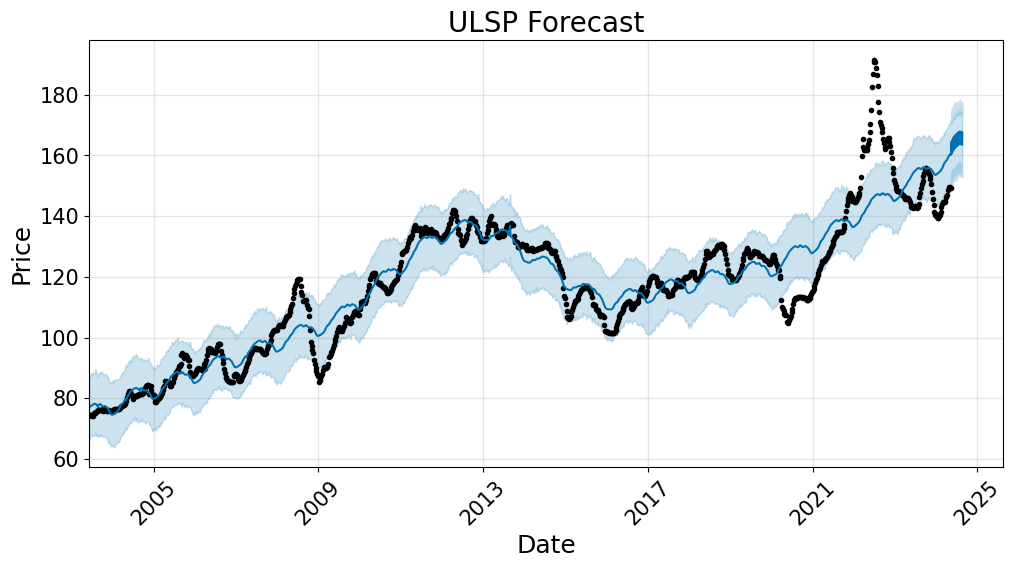

In [12]:
# Time Series cont.
# Import library
import datetime
import matplotlib.pyplot as plt

# Create a data frame for predictions with dates from 13/5/2024 - 21/8/2025
future = model.make_future_dataframe(periods=100)

# Change the column name
future.columns = ['ds']
#future.tail()
# in-sample prediction
prediction = model.predict(future)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("ULSP Forecast", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Price", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2003-06-09', '2025-08-21']))
plt.show();

In [13]:
# Now back to the original challenge, to produce average values by year we need to first identify the year for each data rows - to do this we will split out just the year into a new column for subsequent grouping


In [14]:
from pyspark.sql.functions import year
spark_df2 = spark_df.withColumn('Year', year(spark_df['Date']))
spark_df2.printSchema() # Now see how the schema looks
# Note as the Spark df is 'immutable', we change it by making a new df - thus spark_df goes to spark_df2 and so on.

root
 |-- Date: timestamp (nullable = true)
 |--  ULSP:  Pump price (p/litre): double (nullable = true)
 |-- ULSP:  Diff on previous WEEK (p/litre): double (nullable = true)
 |--  ULSP: Diff on previous  YEAR (p/litre): double (nullable = true)
 |-- Duty rate ULSP (p/litre): double (nullable = true)
 |-- VAT (% rate) ULSP: double (nullable = true)
 |-- ULSD: Pump price (p/litre): double (nullable = true)
 |-- ULSD: Diff on previous WEEK (p/litre): double (nullable = true)
 |-- ULSD: Diff on previous  YEAR (p/litre): double (nullable = true)
 |-- Duty rate ULSD (p/litre): double (nullable = true)
 |-- VAT (% rate) ULSD: double (nullable = true)
 |-- Year: integer (nullable = true)



In [15]:
spark_df3 = spark_df2.drop(spark_df2.Date) # Now we can drop the date column, but again as Spark dfs are immutable, we need to create another
spark_df3.printSchema() # and see how the schema looks

root
 |--  ULSP:  Pump price (p/litre): double (nullable = true)
 |-- ULSP:  Diff on previous WEEK (p/litre): double (nullable = true)
 |--  ULSP: Diff on previous  YEAR (p/litre): double (nullable = true)
 |-- Duty rate ULSP (p/litre): double (nullable = true)
 |-- VAT (% rate) ULSP: double (nullable = true)
 |-- ULSD: Pump price (p/litre): double (nullable = true)
 |-- ULSD: Diff on previous WEEK (p/litre): double (nullable = true)
 |-- ULSD: Diff on previous  YEAR (p/litre): double (nullable = true)
 |-- Duty rate ULSD (p/litre): double (nullable = true)
 |-- VAT (% rate) ULSD: double (nullable = true)
 |-- Year: integer (nullable = true)



In [16]:
# Here's an alternatiive approach we could have used for splitting up the date
# Use pyspark split, to get this we need to first load in the sql functions
#from pyspark.sql import functions as F
#spark_df2 = spark_df.withColumn('Year', F.split(spark_df['Date'], '-').getItem(0)) \
#       .withColumn('Month', F.split(spark_df['Date'], '-').getItem(1)) \
#       .withColumn('Day', F.split(spark_df['Date'], '-').getItem(2))

In [17]:
# Now we can do the grouping by year before we plot it out
# note the way the commands can be chained together with the full stop separator. Note finally the toPandas() converts the spark df to pandas - for the graphing
pd_df = spark_df3.groupby('Year').avg().sort('Year', ascending=[True]).toPandas()
pd_df.set_index(['Year'],drop=True, inplace=True) # an index is needed for the x axis in plots

#from IPython.display import display # print out the result if we want to see the data table
#display(pd_df)
pd_df.info() # print schema to check col names
print('\nCheck that pd_df is a pandas dataframe: ',isinstance(pd_df, pd.DataFrame)) # check it's a panda df

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 2003 to 2024
Data columns (total 11 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   avg( ULSP:  Pump price (p/litre))             22 non-null     float64
 1   avg(ULSP:  Diff on previous WEEK (p/litre))   21 non-null     float64
 2   avg( ULSP: Diff on previous  YEAR (p/litre))  20 non-null     float64
 3   avg(Duty rate ULSP (p/litre))                 22 non-null     float64
 4   avg(VAT (% rate) ULSP)                        22 non-null     float64
 5   avg(ULSD: Pump price (p/litre))               22 non-null     float64
 6   avg(ULSD: Diff on previous WEEK (p/litre))    21 non-null     float64
 7   avg(ULSD: Diff on previous  YEAR (p/litre))   20 non-null     float64
 8   avg(Duty rate ULSD (p/litre))                 22 non-null     float64
 9   avg(VAT (% rate) ULSD)                        22 non-null     float

Text(0, 0.5, 'Fuel Pump Price (p/Litre)')

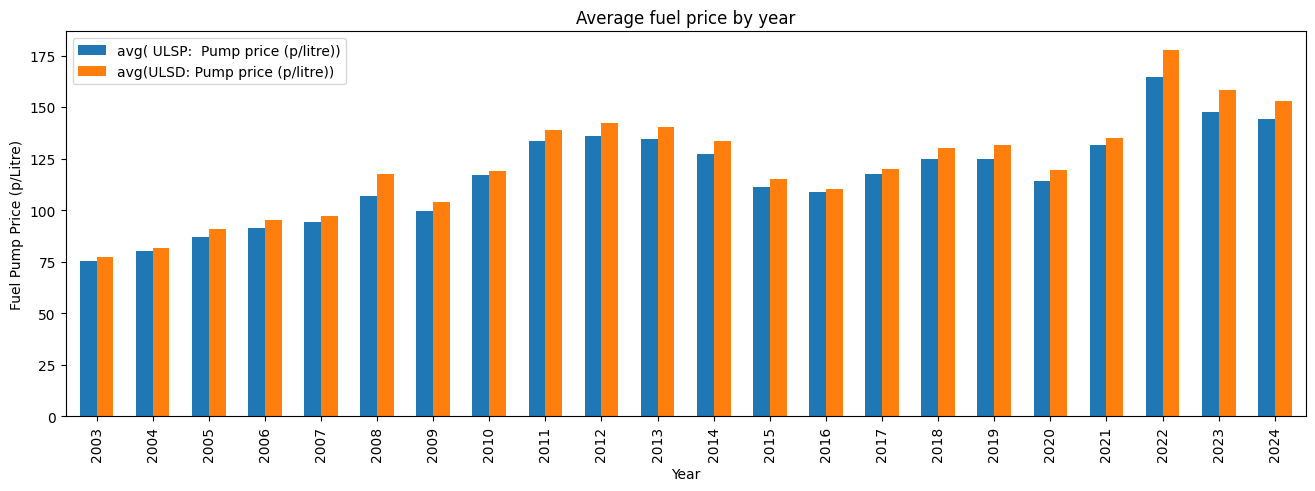

In [18]:
# We will now plot the data - first as a bar chart
# Note here we are using the '.plot()' member function of Pandas to achieve the plot. This is part of Pandas, but uses Matplotlib in the background.
import matplotlib.pyplot as plt
pd_df[['avg( ULSP:  Pump price (p/litre))', 'avg(ULSD: Pump price (p/litre))']].plot(kind="bar", stacked=False, width=0.6, figsize=(16, 5))
plt.title('Average fuel price by year')
plt.xlabel('Year')
plt.ylabel('Fuel Pump Price (p/Litre)')

Text(0, 0.5, 'Fuel Pump Price (p/Litre)')

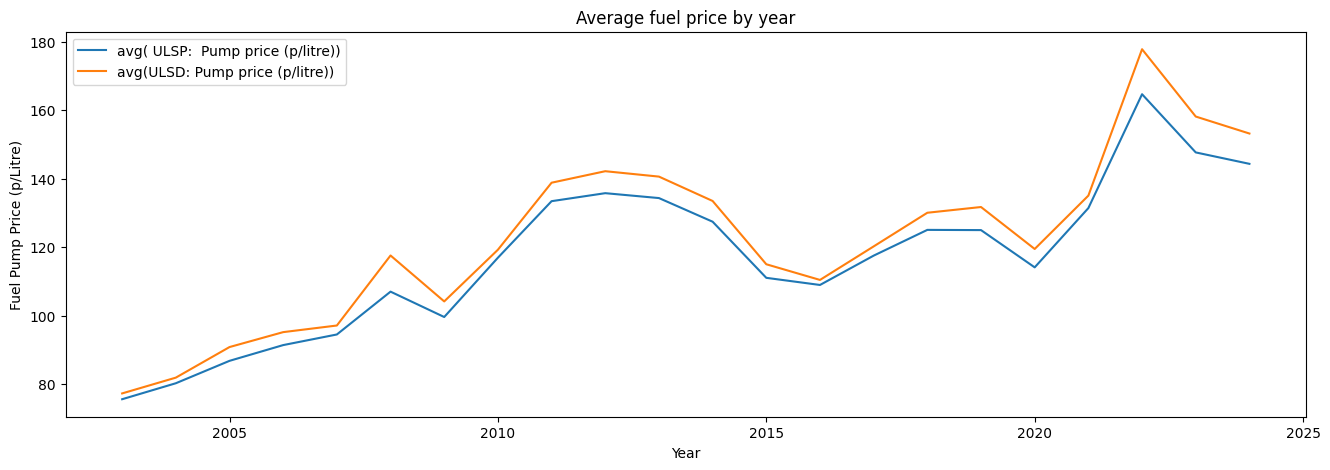

In [19]:
# Using the same approach, we will do a line plot of the same data
import matplotlib.pyplot as plt
pd_df[['avg( ULSP:  Pump price (p/litre))', 'avg(ULSD: Pump price (p/litre))']].plot(kind="line", figsize=(16, 5))
plt.title('Average fuel price by year')
plt.xlabel('Year')
plt.ylabel('Fuel Pump Price (p/Litre)')

# Take a moment at this point to explore the Gemini AI feature to 'explain the code' - this can help your learning! Select the small star icon to the right.

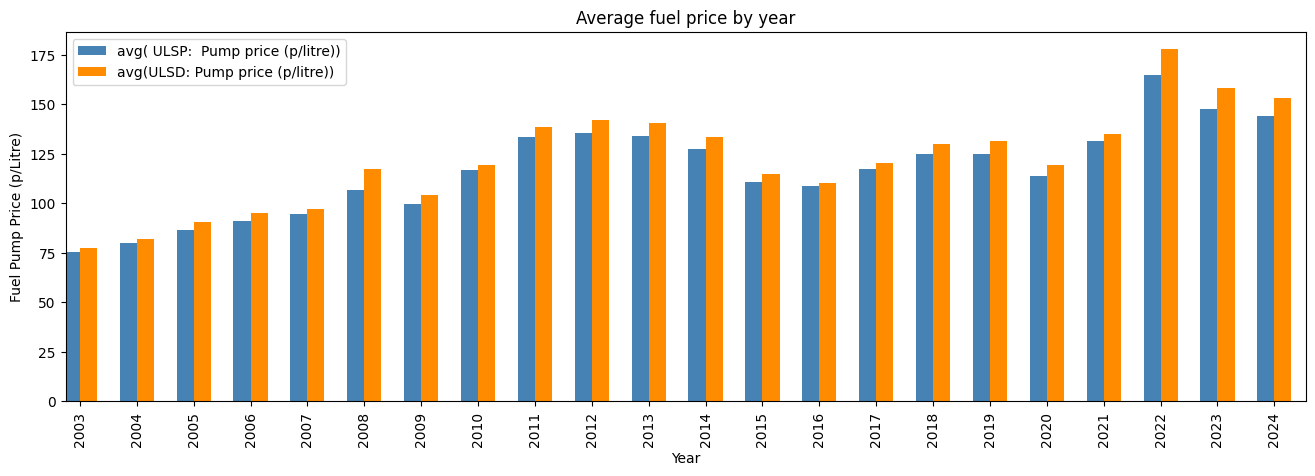

In [20]:
# Here's an alternative bar chart form using MatPlotLib directly - the approach above seems simpler - both plots are the same though!
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_figwidth(16)
axes = plt.axes()
width = 0.3
plt.title('Average fuel price by year')
plt.xlabel('Year')
plt.ylabel('Fuel Pump Price (p/Litre)')
axes.xaxis.set_tick_params(rotation=90)
pd_df.plot(color='steelblue', y='avg( ULSP:  Pump price (p/litre))', width=width, position=1, legend=True, kind='bar', ax=axes)
pd_df.plot(color='darkorange', y='avg(ULSD: Pump price (p/litre))', width=width, position=0, legend=True, kind='bar', ax=axes)
plt.show() # for colours, see https://matplotlib.org/2.0.2/examples/color/named_colors.html

# Problem 2
## Price variation by year

In [21]:
# Distribution of fuel prices in each year
pd_df_box = spark_df3.sort("Year", ascending=[True]).toPandas()
spark_df3.printSchema()

root
 |--  ULSP:  Pump price (p/litre): double (nullable = true)
 |-- ULSP:  Diff on previous WEEK (p/litre): double (nullable = true)
 |--  ULSP: Diff on previous  YEAR (p/litre): double (nullable = true)
 |-- Duty rate ULSP (p/litre): double (nullable = true)
 |-- VAT (% rate) ULSP: double (nullable = true)
 |-- ULSD: Pump price (p/litre): double (nullable = true)
 |-- ULSD: Diff on previous WEEK (p/litre): double (nullable = true)
 |-- ULSD: Diff on previous  YEAR (p/litre): double (nullable = true)
 |-- Duty rate ULSD (p/litre): double (nullable = true)
 |-- VAT (% rate) ULSD: double (nullable = true)
 |-- Year: integer (nullable = true)



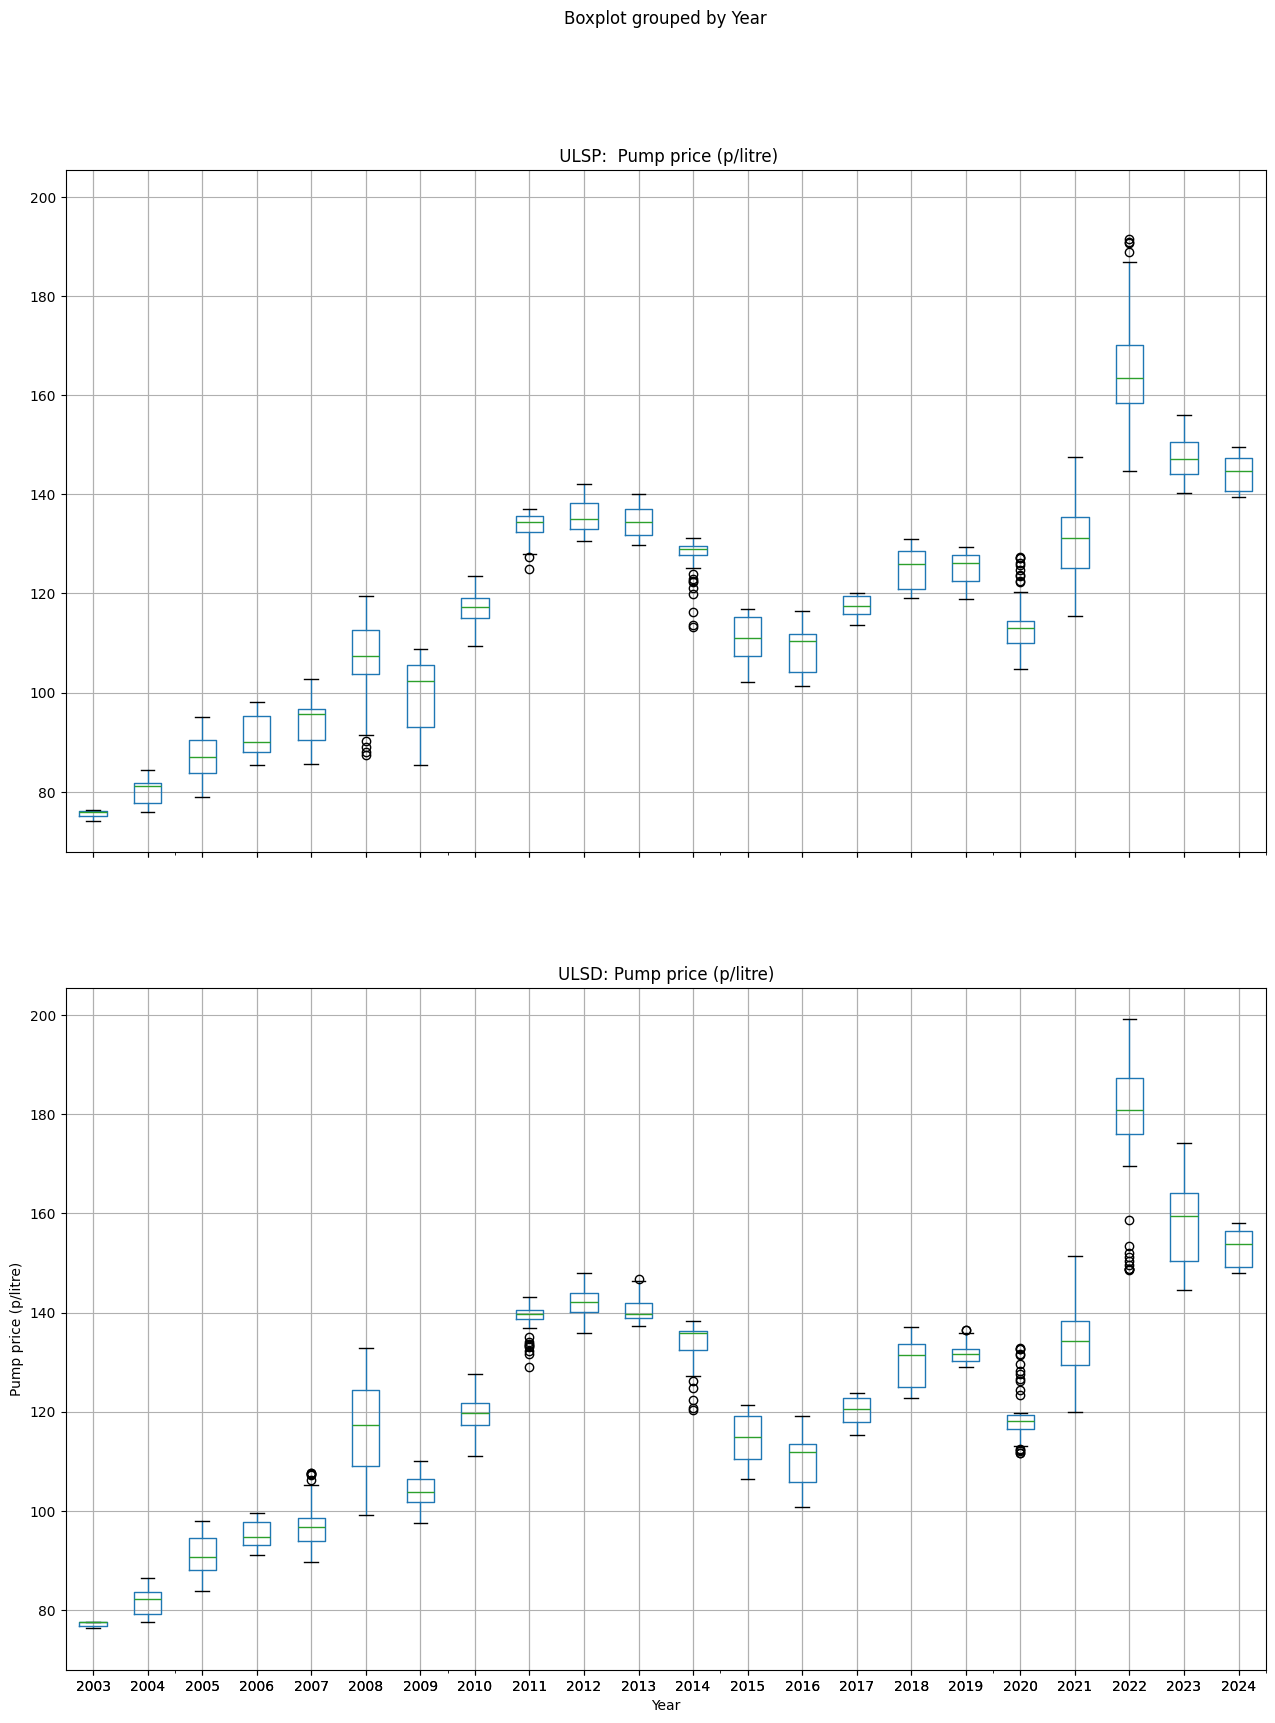

In [22]:
axes = pd_df_box.boxplot(figsize = (15,20), fontsize= '10', grid = True, by = 'Year', column = [' ULSP:  Pump price (p/litre)','ULSD: Pump price (p/litre)'], layout=(2, 1))
#plt.title('Variation in USLP fuel prices by year (2003-2024)')
plt.xlabel('Year') # set up the horizontal 'x' axis label
plt.ylabel('Pump price (p/litre)') # set up the vertical 'y' axis label
plt.show()
# Note, the boxes in this 'box and whisker' plot extend from the Q1 to Q3 quartile values of the data, with a line at the median (Q2), outliers are plotted as separate dots.

# Problem 3
## Additional visualisations
A final challenge, made all the easier by Google CoLab is to see some other potential visualisations of the data.

In CoLab, if you present a Pandas dataframe with the 'display' command as below, CoLab places an option below offering auto-generation of a wide range of graph types. Selecting any of these graphs will provide a further option to show the generated code to produce that graph - very helpful! Click on 'View recommended plots' below the table, then select a graph to see its source code.

In [23]:
from IPython.display import display # print out the result if we want to see the data table
display(pd_df)

,avg( ULSP: Pump price (p/litre)),avg(ULSP: Diff on previous WEEK (p/litre)),avg( ULSP: Diff on previous YEAR (p/litre)),avg(Duty rate ULSP (p/litre)),avg(VAT (% rate) ULSP),avg(ULSD: Pump price (p/litre)),avg(ULSD: Diff on previous WEEK (p/litre)),avg(ULSD: Diff on previous YEAR (p/litre)),avg(Duty rate ULSD (p/litre)),avg(VAT (% rate) ULSD),avg(Year)
Year,,,,,,,,,,,
2003,75.591537,NaN,NaN,46.374667,17.500000,77.287333,NaN,NaN,46.374667,17.500000,2003.0
2004,80.254930,0.098905,NaN,47.100000,17.500000,81.894003,0.140765,NaN,47.100000,17.500000,2004.0
2005,86.796860,0.128936,6.541930,47.100000,17.500000,90.820266,0.132915,8.926263,47.100000,17.500000,2005.0
2006,91.395871,-0.000042,4.598636,47.172115,17.500000,95.179094,0.024717,4.358828,47.172115,17.500000,2006.0
2007,94.495094,0.280087,3.166066,48.878302,17.500000,97.112432,0.268504,1.966864,48.878302,17.500000,2007.0
2008,107.001178,-0.293709,12.378355,50.542308,17.259615,117.556702,-0.162800,20.372919,50.542308,17.259615,2008.0
2009,99.593804,0.388567,-7.407375,54.383846,15.000000,104.146614,0.192734,-13.410088,54.383846,15.000000,2009.0
2010,116.904146,0.305704,17.310342,57.190000,17.500000,119.234615,0.354183,15.088001,57.190000,17.500000,2010.0
2011,133.412774,0.172037,16.508628,58.180769,19.951923,138.805382,0.252479,19.570768,58.180769,19.951923,2011.0
